In [46]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [47]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

In [48]:
#seteo uso de gpu
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [49]:

tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

### smiles_dict

In [50]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [51]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [52]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [53]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [54]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [55]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

In [68]:
X

array(['CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1',
       'O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1',
       'CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1', ...,
       'COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1',
       'COc1cc(C2C3=C(CCCC3=O)NC3=C2C(=O)CCC3)ccc1OCc1ccc(F)cc1',
       'O=C1CCCC2=C1C(c1ccc(OCc3cccc(F)c3)c(Br)c1)C1=C(CCCC1=O)N2'],
      dtype=object)

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [56]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CSc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    print(sme.randomize_smiles('O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F'))

c1(OCc2ccccc2)cccc(-n2c(=O)oc(SC)n2)c1
C1CN(C(=O)n2nc(-c3ccc(Cl)cc3)nc2SCC(F)(F)F)CCC1
c1cc(OCc2ccccc2)cc(-n2c(=O)oc(SC)n2)c1
c1(Cl)ccc(-c2nc(SCC(F)(F)F)n(C(=O)N3CCCCC3)n2)cc1
c1ccc(COc2cc(-n3nc(SC)oc3=O)ccc2)cc1
c1c(-c2nc(SCC(F)(F)F)n(C(N3CCCCC3)=O)n2)ccc(Cl)c1
CSc1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
C1N(C(=O)n2nc(-c3ccc(Cl)cc3)nc2SCC(F)(F)F)CCCC1
c1c(OCc2ccccc2)cccc1-n1nc(SC)oc1=O
c1(SCC(F)(F)F)nc(-c2ccc(Cl)cc2)nn1C(=O)N1CCCCC1
CSc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
O=C(N1CCCCC1)n1c(SCC(F)(F)F)nc(-c2ccc(Cl)cc2)n1
O(Cc1ccccc1)c1cc(-n2c(=O)oc(SC)n2)ccc1
c1(SCC(F)(F)F)n(C(=O)N2CCCCC2)nc(-c2ccc(Cl)cc2)n1
n1c(SC)oc(=O)n1-c1cccc(OCc2ccccc2)c1
C(=O)(n1c(SCC(F)(F)F)nc(-c2ccc(Cl)cc2)n1)N1CCCCC1
c1cccc(COc2cccc(-n3nc(SC)oc3=O)c2)c1
FC(F)(CSc1n(C(=O)N2CCCCC2)nc(-c2ccc(Cl)cc2)n1)F
S(c1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1)C
FC(CSc1n(C(=O)N2CCCCC2)nc(-c2ccc(Cl)cc2)n1)(F)F


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [57]:
from datagen import DataGenerator

In [58]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [59]:
len(dgen) * dgen.batch_size

5104

In [60]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
len(X_train), len(y_train), len(X_test)

(4082, 4082, 1021)

In [64]:
X_train

array(['COc1ccccc1C(=O)Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2',
       'c1ccc2oc(CNCCCCCCCNc3c4c(nc5ccccc35)CCCC4)cc2c1',
       'C=C1c2cc(Cl)ccc2N=C2CCCCCN12', ...,
       'O=C(Cc1cc(=O)oc2cc(O)ccc12)N/N=C1\\SCC(=O)N1c1c2c(nc3ccccc13)CCCC2',
       'O=C(NCCCCCc1ccccc1)Oc1ccc(-n2cc(COc3ccc4ccc(=O)oc4c3)nn2)cc1',
       'CN(C)Cc1ccc(CSCCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [65]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [67]:
dgen_train[0]

(array([[16,  7, 16, ...,  0,  0,  0],
        [28,  7,  2, ...,  0,  0,  0],
        [16,  7, 31, ...,  0,  0,  0],
        ...,
        [16,  7, 16, ...,  0,  0,  0],
        [21, 15, 16, ...,  0,  0,  0],
        [16,  7, 24, ...,  0,  0,  0]]),
 array([6.1426675 , 7.00788851, 7.87614836, 6.40893539, 5.39794001,
        7.92081875, 7.        , 4.77989191, 4.60084567, 8.60205999,
        5.52287875, 4.95330978, 7.39924485, 4.26760624, 6.74472749,
        7.36653154, 4.91364017, 4.        , 8.09691001, 6.52287875,
        5.95078198, 4.31000002, 6.69250396, 5.95860731, 7.74472749,
        2.947     , 4.88372441, 5.05799195, 4.64016452, 7.28399666,
        6.61978876, 8.11861534, 7.52287875, 9.22914799, 5.14999987,
        5.23657201, 6.02641038, 3.30103   , 5.62525165, 5.        ,
        6.85387196, 4.        , 5.17263073, 5.5559552 , 5.25181197,
        7.15926677, 6.84499816, 5.77000093, 2.8827287 , 4.67985371,
        4.81247928, 4.        , 5.7212464 , 6.37161107, 9.18708664,
   

In [66]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [21]:
X_b.shape

(125, 227)

# Network Model

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [23]:
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(input_dim = vocab_size + 1, output_dim = embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', activation='relu')(embedding)
        max_p = L.MaxPool1D(pool_size=2, strides=1)(conv)
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(200, activation='relu')(dense)
    dense = L.Dense(50, activation='relu')(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

In [24]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (2, 3, 5, 8, 13)
NUM_FILTERS = 32
vocab_size = len(smiles_dict)
embeddings_size = 200

In [25]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 200)     8600        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 227, 32)      12832       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 227, 32)      19232       embedding[0][0]                  
______________________________________________________________________________________________

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 200)     8600        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 227, 32)      12832       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 227, 32)      19232       embedding[0][0]                  
______________________________________________________________________________________________

In [27]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [29]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [30]:
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test)

Epoch 1/100
32/32 [==============================] - 10s 164ms/step - loss: 4.9546 - R2: -0.9219 - val_loss: 2.4751 - val_R2: 0.1368
Epoch 2/100
32/32 [==============================] - 3s 99ms/step - loss: 2.3160 - R2: 0.1637 - val_loss: 2.3992 - val_R2: 0.1731
Epoch 3/100
32/32 [==============================] - 3s 102ms/step - loss: 2.2125 - R2: 0.2073 - val_loss: 2.1953 - val_R2: 0.2446
Epoch 4/100
32/32 [==============================] - 3s 97ms/step - loss: 2.0667 - R2: 0.2572 - val_loss: 2.1230 - val_R2: 0.2466
Epoch 5/100
32/32 [==============================] - 3s 100ms/step - loss: 2.0176 - R2: 0.2712 - val_loss: 2.0905 - val_R2: 0.2803
Epoch 6/100
32/32 [==============================] - 3s 100ms/step - loss: 2.0659 - R2: 0.2538 - val_loss: 2.1018 - val_R2: 0.2737
Epoch 7/100
32/32 [==============================] - 3s 102ms/step - loss: 1.9736 - R2: 0.2932 - val_loss: 2.0913 - val_R2: 0.2731
Epoch 8/100
32/32 [==============================] - 4s 116ms/step - loss: 1.9269 -

In [43]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [44]:
X_test_eval.shape, y_test.shape

((1021, 227), (1021,))

In [45]:
y_pred = model.predict(X_test_eval)

# Score

In [34]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [35]:
r2


0.6014829262237769

In [36]:
filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model.save(filename)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 227, 200)     8600        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 227, 32)      12832       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 227, 32)      19232       embedding[0][0]                  
______________________________________________________________________________________________

# Load model (solo si se grabo el modelo)

In [38]:
from tensorflow.keras.models import load_model

In [39]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [40]:
y_pred = model_loaded.predict(X_test_eval)

In [41]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.6014829262237769

# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

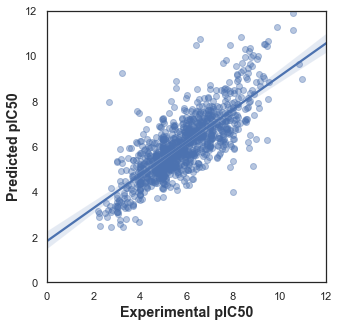

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show